In [1]:
!pip install python-louvain

In [2]:
import cudf, cuml
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


In [3]:
cudf_df = cudf.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
print(cudf_df.columns)
# labels = train_data['isFraud']
# cudf_df = train_data[[col for col in train_data.columns if col.startswith("V")]]
# import gc
# del train_data
# gc.collect()
# cudf_df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)


In [4]:
V_groups = [['V279', 'V280', 'V293', 'V294', 'V295', 'V306', 'V307', 'V308', 'V316', 'V317', 'V318'],
            ['V298', 'V299', 'V297'],
            ['V285', 'V287'], ['V290', 'V292', 'V291'], ['V302', 'V303', 'V304'], 
            ['V309', 'V311'], ['V319', 'V321', 'V320'], 
            ['V95', 'V96', 'V97', 'V101', 'V102', 'V103', 'V105', 'V126', 'V127', 'V128', 'V132', 'V133', 'V134'],
            ['V106', 'V104'], ['V99', 'V100'], ['V108', 'V110'], ['V111', 'V113', 'V112'], 
            ['V114', 'V116'], ['V117', 'V119'], ['V123', 'V125'], ['V135', 'V137', 'V136'],
            ['V288', 'V289'], ['V300', 'V301'], ['V313', 'V315', 'V314'], ['V12', 'V13'],
            ['V15', 'V16', 'V31', 'V33', 'V34'], ['V17', 'V18', 'V21', 'V32', 'V22'], 
            ['V19', 'V20'], ['V23', 'V24'], ['V25', 'V26'], ['V27', 'V28'], ['V29', 'V30'],
            ['V53', 'V54'], ['V57', 'V58', 'V72', 'V73', 'V74'], ['V59', 'V63', 'V71', 'V60', 'V64'],
            ['V61', 'V62'], ['V66', 'V67'], ['V69', 'V70'], ['V75', 'V76'], ['V79', 'V94'],
            ['V85', 'V92', 'V93', 'V80', 'V81', 'V84'], ['V82', 'V83'], ['V86', 'V87'],
            ['V90', 'V91'], ['V35', 'V36'], ['V37', 'V38'], ['V39', 'V40', 'V42', 'V43'],
            ['V50', 'V51', 'V52'], ['V44', 'V45'], ['V48', 'V49'], ['V4', 'V5'], ['V8', 'V9'],
            ['V10', 'V11'], ['V221', 'V222'], ['V245', 'V259', 'V227', 'V255', 'V256'],
            ['V238', 'V239'], ['V250', 'V251'], ['V270', 'V271', 'V272'], 
            ['V170', 'V200', 'V188', 'V189', 'V201'], ['V184', 'V185'],
            ['V194', 'V195', 'V197', 'V198'], 
            ['V167', 'V168', 'V177', 'V178', 'V179', 'V202', 'V203', 'V204', 'V211', 'V212', 'V213'],
            ['V182', 'V183', 'V181'], ['V172', 'V186', 'V191', 'V196', 'V207', 'V193', 'V187', 'V192'],
            ['V176', 'V190', 'V199'], ['V214', 'V216', 'V215'], 
            ['V217', 'V218', 'V219', 'V231', 'V232', 'V233', 'V237', 'V273', 'V274', 'V275', 'V236', 'V235'], 
            ['V224', 'V225', 'V229', 'V248', 'V253', 'V254', 'V261', 'V267', 'V230', 'V243', 'V249', 'V258', 'V262', 'V268'], 
            ['V228', 'V246', 'V242', 'V244', 'V257'], ['V247', 'V252'], ['V263', 'V265', 'V264'], ['V266', 'V269'],
            ['V276', 'V277', 'V278'], ['V322', 'V323', 'V324', 'V331', 'V332', 'V333'], 
            ['V329', 'V330', 'V326', 'V327', 'V328'], ['V338', 'V337', 'V339'], ['V334', 'V336', 'V335'],
            ['V143', 'V164', 'V165'], ['V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160'], ['V139', 'V140'], 
            ['V141', 'V142'], ['V146', 'V147'], ['V148', 'V149', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158'],
            ['V161', 'V162', 'V163']]

In [5]:
print(len(V_groups))

79


In [6]:
#split transaction amount into dollars and cents
cudf_df['TransactionAmt_cents'] = cudf_df['TransactionAmt'] - cp.floor(cudf_df['TransactionAmt'])
cudf_df['TransactionAmt_dollars'] = cudf_df['TransactionAmt'] - cudf_df['TransactionAmt_cents']



In [7]:
def plot_graph(G, partitions):
    # Add partitions as node attributes
    nx.set_node_attributes(G, partitions, "partition")
    # Generate positions for the graph
    pos = nx.spring_layout(G)  # Spring layout for a visually appealing structure
    # Extract partition colors
    partition_colors = [partitions[node] for node in G.nodes()]
    # Plot the graph
    plt.figure(figsize=(4, 4))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=partition_colors,
        cmap=plt.cm.tab20,
        node_size=500,
        font_size=10,
        edge_color='gray'
    )
    plt.title("Graph Visualization with Spring Layout and Partitions")
    plt.show()
    

In [60]:
def plot_distributions(cols_list, log=False):
    num_columns = len(cols_list)

    # Define the number of rows and columns for the grid
    ncols = 2
    nrows = (num_columns + ncols - 1) // ncols  # Calculate rows needed for given columns

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
    axes = axes.flatten()  # Flatten in case of a 2D array of axes

    for i, column in enumerate(cols_list):
        ax = axes[i]

        # Filter out non-positive values
        if log:
            valid_data = np.log10(cudf_df[column][cudf_df[column] > 0].to_numpy())
            scale = "log"
        else:
            valid_data = cudf_df[column].dropna().to_numpy()
            scale = ""
        # Plot histogram of log-transformed data
        ax.hist(valid_data, bins=30, alpha=0.7, edgecolor='black')
        ax.set_title(f'{scale} Distribution of {column}', fontsize=14)
        ax.set_xlabel(f'{scale} ({column})')
        ax.set_ylabel('Frequency')

    # Hide any unused subplots
    for j in range(len(cols_list), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [61]:
def plot_correlation_distribution(correlation_matrix):
    correlation_values = correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]  # k=1 excludes diagonal

    # Step 3: Plot the distribution of correlation values
    plt.figure(figsize=(8, 6))
    plt.hist(correlation_values, bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Correlation Coefficients', fontsize=14)
    plt.xlabel('Correlation Coefficient', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()

In [63]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

def group_cols(cols_list, log=False):
    correlation_matrix = cudf_df[cols_list].corr().to_numpy()
    plot_correlation_distribution(correlation_matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm", 
        cbar=True, 
        xticklabels=cols_list, 
        yticklabels=cols_list
    )
    plt.title("Correlation Matrix of Selected Columns")
    plt.xlabel("Columns")
    plt.ylabel("Columns")
    plt.show()

    # Create a graph based on the correlation threshold
    threshold = 0.8
    G = nx.Graph()

    for idx, col in enumerate(cols_list):
        G.add_node(idx, label=col)

    # Add edges for correlations above the threshold
    for i, j in itertools.combinations(range(len(cols_list)), 2):
        if correlation_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=abs(correlation_matrix[i, j]))

    communities = greedy_modularity_communities(G)

    # Map community structure
    community_mapping = {}
    for idx, community in enumerate(communities):
        for node in community:
            community_mapping[node] = idx

    # Plot the graph with community coloring and labeled nodes
    pos = nx.spring_layout(G)  # Layout for better visualization
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color=[community_mapping[node] for node in G.nodes()], cmap=plt.cm.Set3, node_size=500)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, {i: C_cols[i] for i in G.nodes()}, font_size=10)
    plt.title("NetworkX Graph with Greedy Modularity Community Detection")
    plt.show()

    # Group columns by community
    grouped_cols = [[cols_list[node] for node in community] for community in communities]

    # Print grouped columns
    print("Grouped Columns by Community:")
    for idx, cols in enumerate(grouped_cols):
        print(f"Community {idx}: {cols}")
        
    print(cudf_df[cols_list].describe())    
    plot_distributions(cols_list, log)
    return grouped_cols

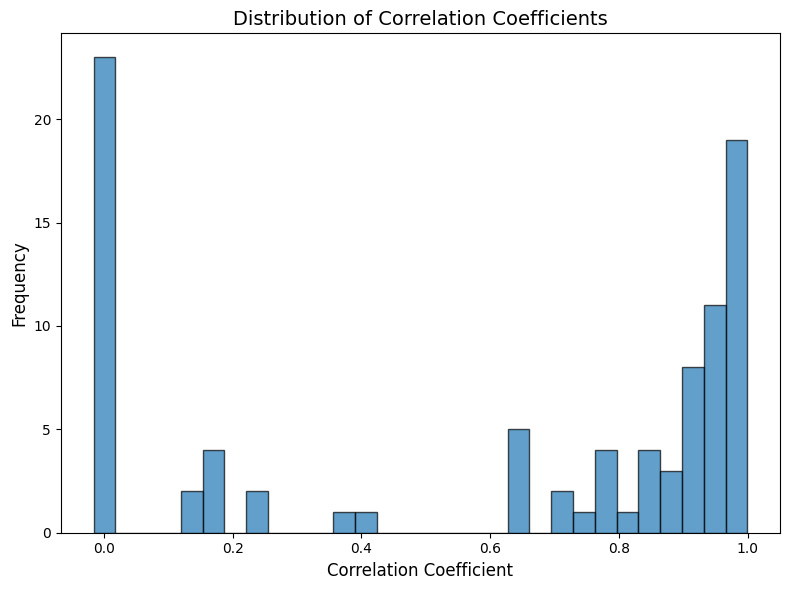

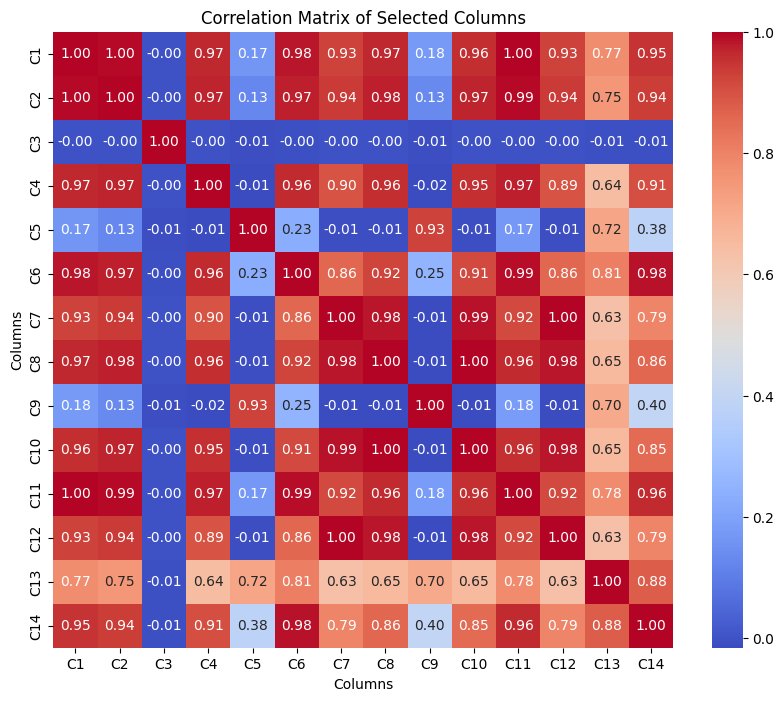

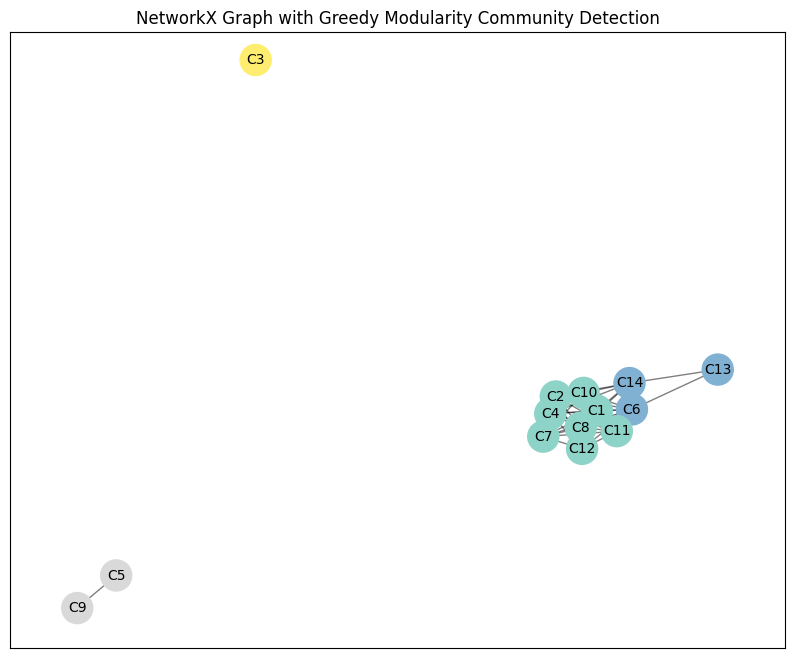

Grouped Columns by Community:
Community 0: ['C1', 'C2', 'C4', 'C7', 'C8', 'C10', 'C11', 'C12']
Community 1: ['C14', 'C13', 'C6']
Community 2: ['C9', 'C5']
Community 3: ['C3']
                  C1             C2             C3             C4  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       14.092458      15.269734       0.005644       4.092185   
std       133.569018     154.668899       0.150536      68.848459   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       0.000000   
max      4685.000000    5691.000000      26.000000    2253.000000   

                  C5             C6             C7             C8  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        5.571526       9.071082       2.848478       5.144574

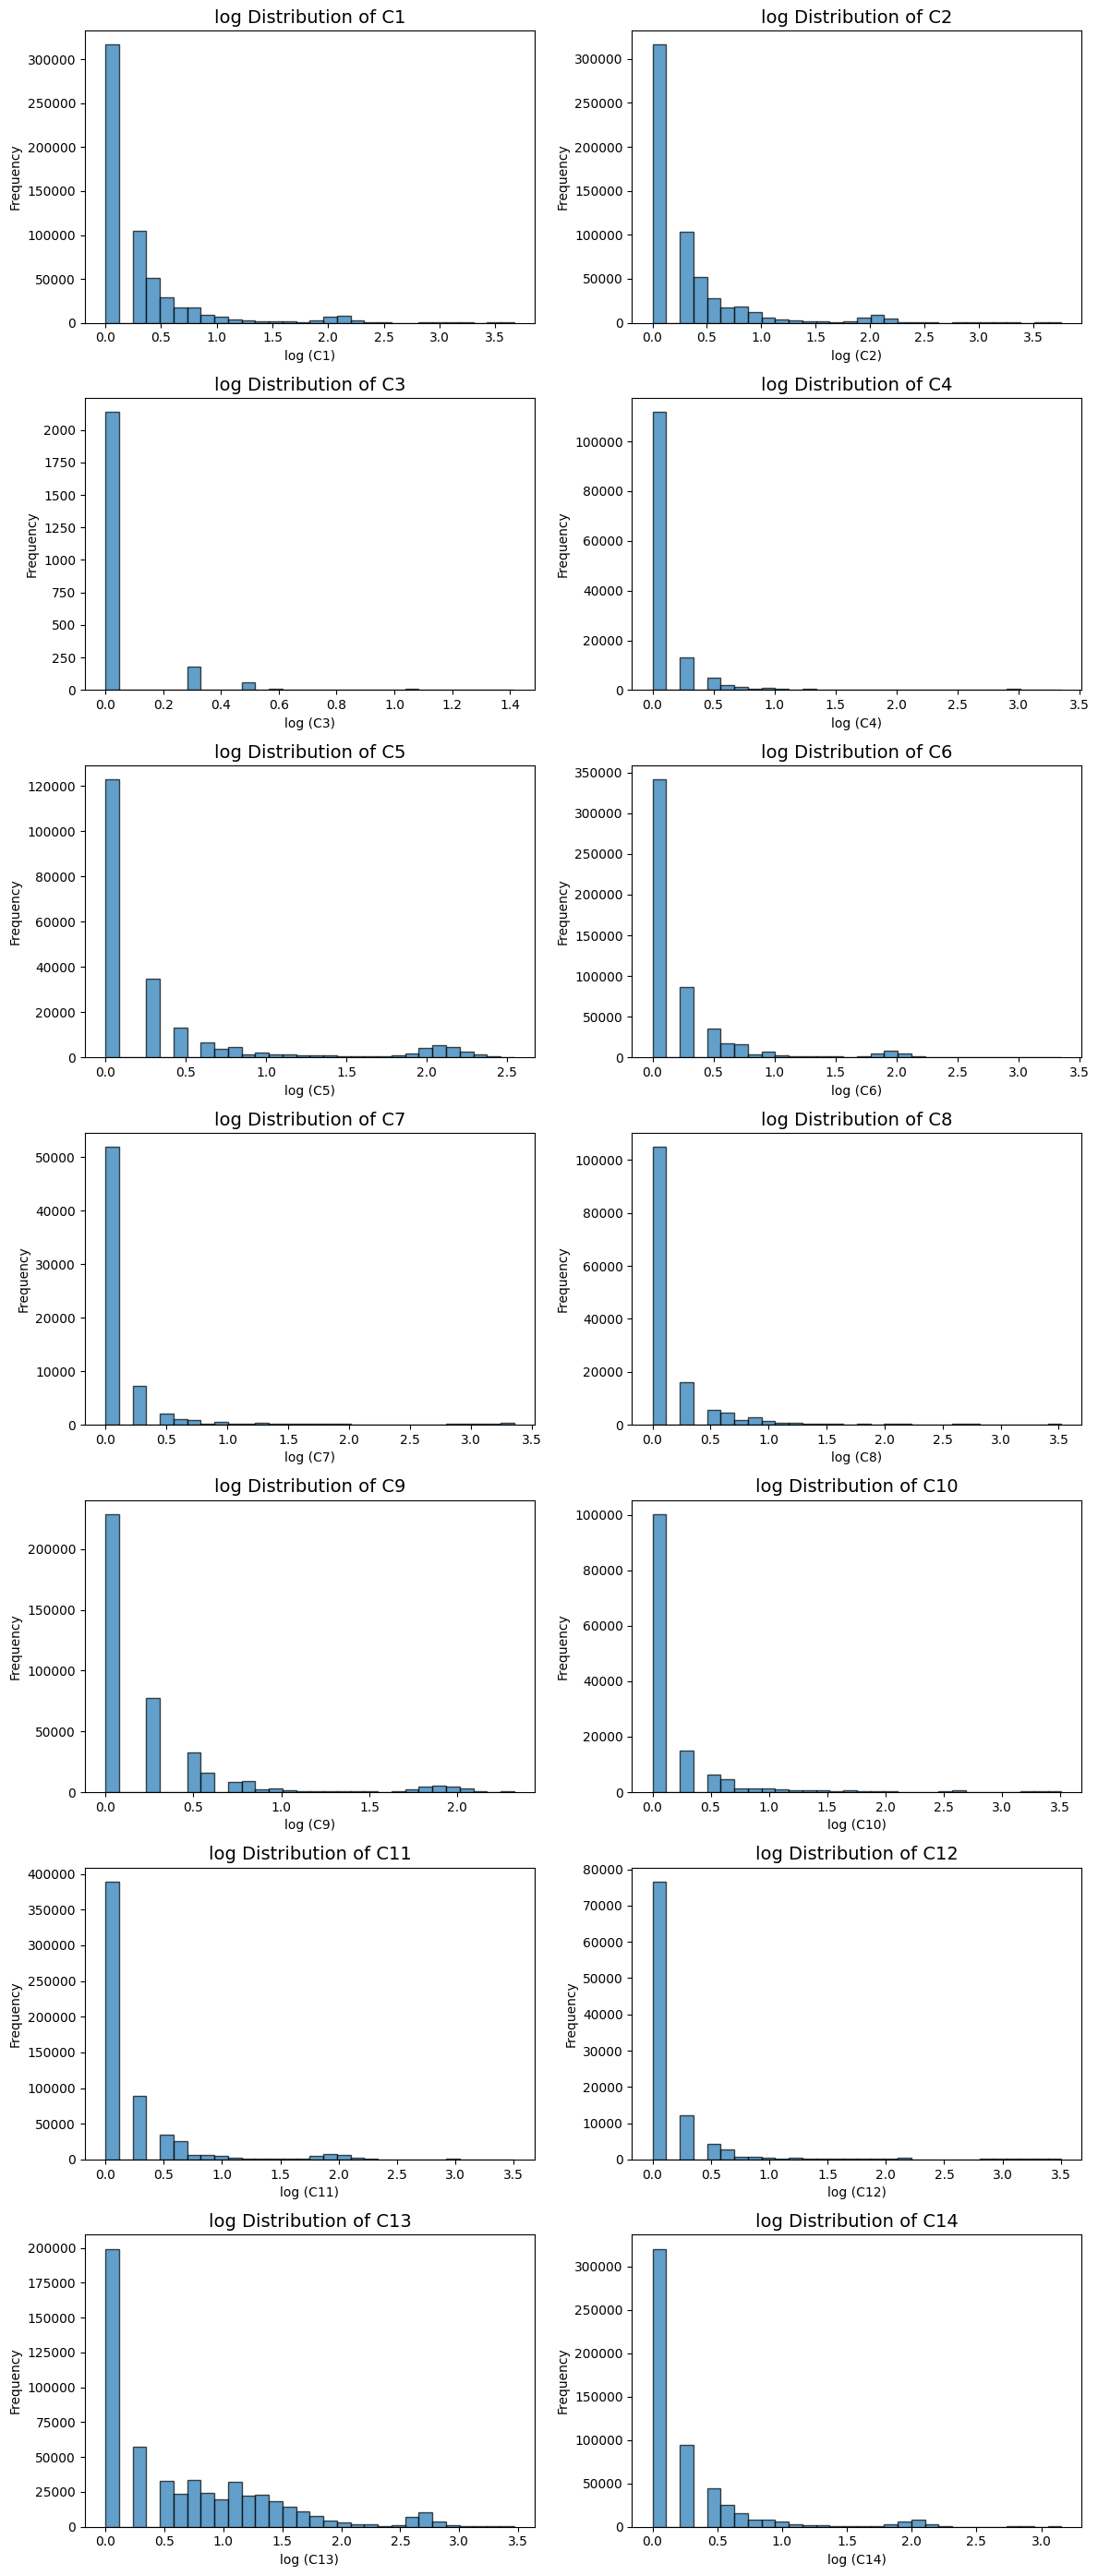

In [65]:
#C cols
C_cols = [col for col in cudf_df.columns if col.startswith('C') and '_' not in col]
grouped_C_cols = group_cols(C_cols, log=True)

In [38]:
print(grouped_C_cols)

[['C1', 'C2', 'C4', 'C7', 'C8', 'C10', 'C11', 'C12'], ['C14', 'C13', 'C6'], ['C9', 'C5'], ['C3']]


In [42]:
for idx, group in enumerate(grouped_C_cols):
    cudf_df[f"Cnew_{idx}"] = cudf_df[group].mean(axis=1)

In [43]:
cudf_df[[f"Cnew_{idx}" for idx in range(len(grouped_C_cols))]].describe()

,Cnew_0,Cnew_1,Cnew_2,Cnew_3
count,590540.000000,590540.000000,590540.000000,590540.000000
mean,7.625690,16.635405,5.025883,0.005644
std,97.315787,79.948313,20.851781,0.150536
min,0.125000,0.000000,0.000000,0.000000
25%,0.375000,1.000000,0.000000,0.000000
50%,0.750000,1.666667,0.500000,0.000000
75%,1.125000,5.666667,1.500000,0.000000
max,3481.000000,2200.000000,240.000000,26.000000


                  D1             D2             D3             D4  \
count  589271.000000  309743.000000  327662.000000  421618.000000   
mean       94.347568     169.563231      28.343348     140.002441   
std       157.660387     177.315865      62.384721     191.096774   
min         0.000000       0.000000       0.000000    -122.000000   
25%         0.000000      26.000000       1.000000       0.000000   
50%         3.000000      97.000000       8.000000      26.000000   
75%       122.000000     276.000000      27.000000     253.000000   
max       640.000000     640.000000     819.000000     869.000000   

                  D5            D6            D7            D8            D9  \
count  280699.000000  73187.000000  38917.000000  74926.000000  74926.000000   
mean       42.335965     69.805717     41.638950    146.058108      0.561057   
std        89.000144    143.669253     99.743264    231.663840      0.316880   
min         0.000000    -83.000000      0.000000      0.00

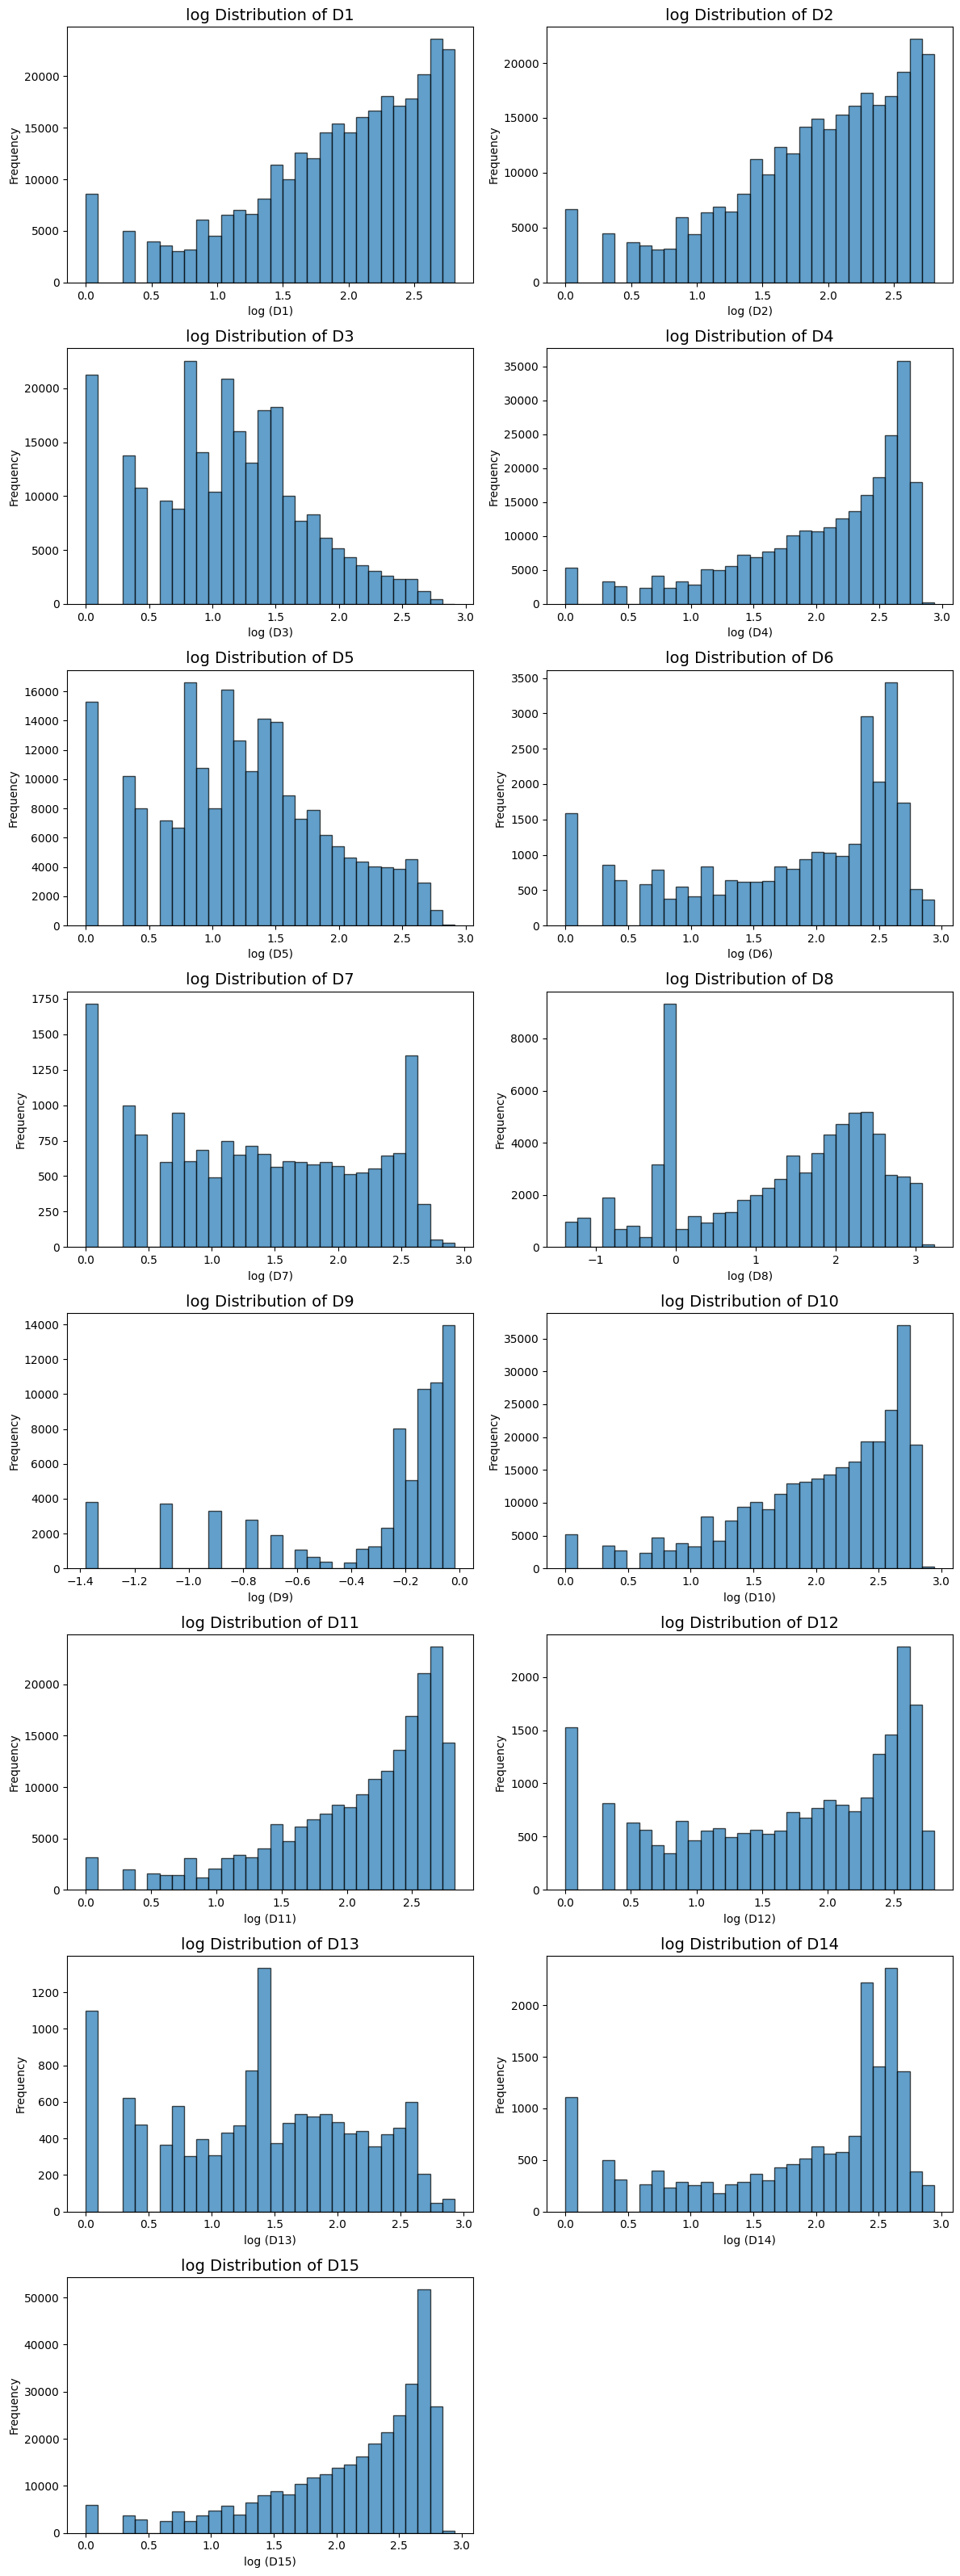

In [66]:
D_cols = [col for col in cudf_df.columns if col.startswith('D')]
print(cudf_df[D_cols].describe())
plot_distributions(D_cols, log=True)

In [48]:
print(cudf_df[D_cols].isna().sum(axis=0))

D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
dtype: int64
